# San Francisco Airbnb Exploratory Data Analysis

Haoming Jin

In [2]:
import numpy as np
import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_original = pd.read_pickle('airbnb_SF_2019_04_to_2020_04.pkl')

The Data is downloaded and cleaned in the previous notebook:[San_Francisco_Airbnb_Data_Cleaning.ipynb](https://github.com/carterjin/Capstion-Project-San-Francisco-Airbnb-Data-Analysis-and-Machine-Learning-Price-Prediction/blob/master/San_Francisco_Airbnb_Data_Cleaning.ipynb) and saved as a pickle file.

In this notebook we do some exploratory data analysis.

We answer the following questions:

1. What are the locations that people rent Airbnb?
2. How does neighborhood affect pricing?
3. Do superhosts provide a better renting experience?
4. Can we provide a prediction on pricing given the information we are provided, if so which method does that best?

for reference the data contains the following information:

In [4]:
df_original.info(verbose = True, null_counts= True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12074 entries, 0 to 7275
Data columns (total 83 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            12074 non-null  object        
 1   last_scraped                                  12074 non-null  datetime64[ns]
 2   name                                          12074 non-null  object        
 3   summary                                       11730 non-null  object        
 4   space                                         10064 non-null  object        
 5   description                                   11947 non-null  object        
 6   neighborhood_overview                         8759 non-null   object        
 7   notes                                         6860 non-null   object        
 8   transit                                       8106 non-null   objec

For ease of handling I am taking a few columns that I think I can explore with.

In [4]:
col_lists = ['id','host_name','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost',
            'host_total_listings_count','neighbourhood_cleansed','latitude','longitude','is_location_exact','property_type',
            'room_type', 'accommodates','bathrooms','bedrooms','beds','bed_type','price','weekly_price','monthly_price',
            'security_deposit','cleaning_fee','guests_included']
df = df_original[col_lists]

## 1. What are the locations that people rent Airbnb?

First I would like to have a visual inspection of how the data looks on the map

### Some map visualizations

The density of all locations is plotted as a heatmap.

In [7]:
def display_listing_heatmap(df):
    '''
    Use folium library to generate and display an interactive heatmap of the Airbnb listings.

    INPUT: Airbnb listing pandas DataFrame containing latitude and longitude
    OUTPUT: None
    '''
    import folium
    from folium.plugins import HeatMap
    m=folium.Map([37.76,-122.44,],zoom_start=13)
    HeatMap(df[['latitude','longitude']].dropna(),radius=8,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(m)
    display(m)
display_listing_heatmap(df)

The prices are plotted on the map as colored dots.

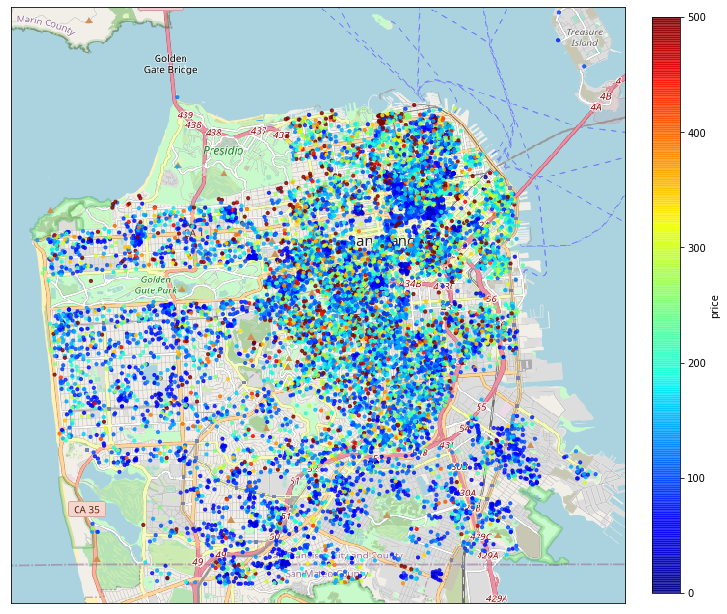

In [8]:
def display_price_on_map(df):
    '''
    Show listing price as colored dots on map.
    
    INPUT: Airbnb listing pandas DataFrame containing 'longitude', 'latitude', and 'price' columns.
    OUTPUT: None
    Dependence: Needs the map image of SF, longitude range (-122.52,-122.3594) and latitude range(37.7,37.83),
                Can be generated by OpenStreet API.

    '''
    BBox = [-122.52,-122.3594,37.7,37.83]
    north_CA_map = plt.imread('SF_map.png')
    fig, ax = plt.subplots(figsize = (12,12))
    xbins = np.arange(BBox[0],BBox[1]+0.001, 0.001)
    ybins = np.arange(BBox[2],BBox[3]+0.001, 0.001)

    #ax.hist2d('longitude', 'latitude', bins = [xbins,ybins], data = df, cmap = 'winter', cmin = 2)
    im = ax.scatter(df.longitude, df.latitude, zorder=1, alpha= 0.8, c = df.price, cmap = plt.get_cmap('jet'), 
                    s=10 ,vmax = 500)
    fig.colorbar(im, ax = ax, fraction = 0.043, pad = 0.04, label = 'price')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])

    ax.imshow(north_CA_map, zorder=0, extent = BBox, aspect= 1.2)
    plt.xticks([])
    plt.yticks([]);
display_price_on_map(df)

We can see that the higher priced listings are mostly in the central areas and houses very close to the coast.

## 2. How does neighborhood affect pricing?

Which neighbourhoods have the highest number of hosts and what is the price distribution of each neighborhood?

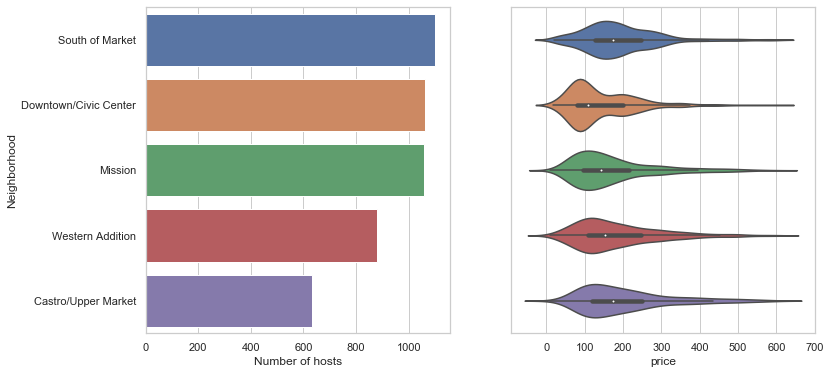

In [9]:
def display_neighbour(df):
    '''
    Displays a bar plot showing the five neighbourhood with highest listing counts, 
    and the violin plot of the price distribution within the neighbourhood
    
    INPUT: Airbnb listing pandas DataFrame with columns 'neighbourhood_cleansed', 'price'.
    OUTPUT: None
    '''
    sns.set(style = 'whitegrid')
    neighbour_list = df.neighbourhood_cleansed.value_counts()[0:5]
    neighbour_count = np.array(neighbour_list)
    neighbour_list = np.array(neighbour_list.index)
    fig, ax = plt.subplots(1,2,figsize = (12,6))

    sns.barplot(x = neighbour_count, y = neighbour_list, ax = ax[0])
    df_sub = df.query('neighbourhood_cleansed in @neighbour_list and price < 600')

    sns.violinplot(data = df_sub, y='neighbourhood_cleansed', x ='price',order = neighbour_list, ax = ax[1]);
    #plt.xticks(rotation = 20)
    ax[0].set_ylabel('Neighborhood')
    ax[0].set_xlabel('Number of hosts')
    ax[1].set_ylabel('')
    ax[1].set_yticks([]);
display_neighbour(df)

The following plot shows the locations in these neighbourhoods on the map.

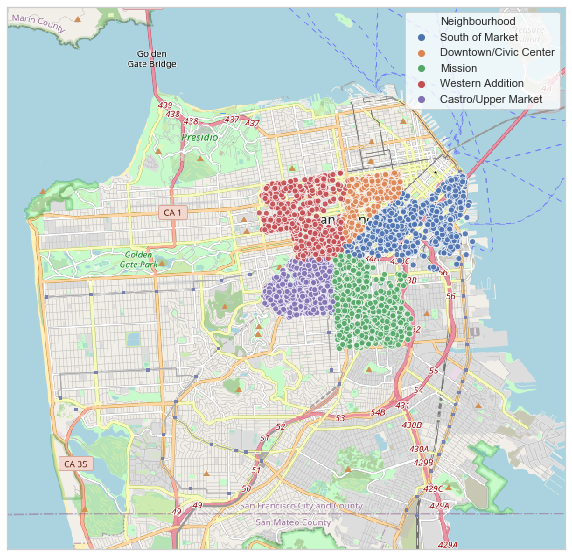

In [44]:
def display_neighbour_on_map(df):
    '''
    Display the five neighbourhoods with highest listing counts and the corresponding listings on the map.
    
    INPUT: airbnb listing pandas DataFrame with columns 'longitude', 'latitude', and 'neighbourhood_cleansed'.
    OUTPUT: None
    Dependence: Needs the map image of SF, longitude range (-122.52,-122.3594) and latitude range(37.7,37.83),
                Can be generated by OpenStreet API.
    '''
BBox = [-122.52,-122.3594,37.7,37.83]
north_CA_map = plt.imread('SF_map.png')
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(data = df_sub, x = 'longitude', y = 'latitude', hue = 'neighbourhood_cleansed',
                hue_order = neighbour_list,alpha = 0.9,ax = ax)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

ax.imshow(north_CA_map, zorder=0, extent = BBox, aspect= 1.2)
(ax.legend()).texts[0].set_text('Neighbourhood')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

Most of the listings are in the central and north-east coastal areas. Also, Downtown/Civic Center area have the lowest average price, but there is a clear seperation of a group of higher prices around 200, and another group of lower prices around 90.

## 3. Do superhosts provide a better renting experience?

What is the ratio of regular hosts vs superhosts? Do superhosts have higher rating in these aspects:

1. Overall: The overall experience.
2. Accuracy: How accurately did the listing page represent the space?
3. Cleanliness: Did guests feel that the space was clean and tidy?
4. Check-in: How smoothly did check-in go?
5. Communication: How well did you communicate before and during the stay? Guests often care that their host responds quickly, reliably, and frequently to their messages and questions.
6. Location: How did guests feel about the neighborhood? This may mean that there's an accurate description for proximity and access to transportation, shopping centers, city center, etc., and a description that includes special considerations, like noise, and family safety.
7. Value: Did the guest feel that the listing provided good value for the price?



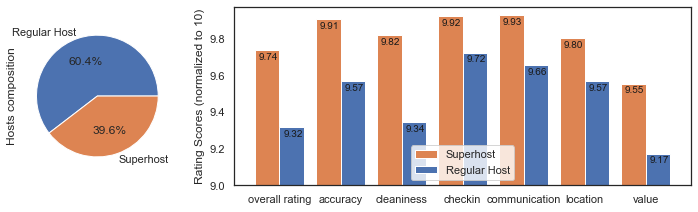

In [45]:
def display_superhost_rating_compare(df):


ratings = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
           'review_scores_communication','review_scores_location','review_scores_value']
super_ratings = df_original[['host_is_superhost']+ratings].dropna().query('host_is_superhost == True').mean()[1:]
super_ratings[0] /= 10
reg_ratings = df_original[['host_is_superhost']+ratings].dropna().query('host_is_superhost != True').mean()[1:]
reg_ratings[0] /= 10

sns.set(style = 'white')
fig, ax = plt.subplots(1,2, figsize = (12,6),gridspec_kw={'width_ratios': [1,3]})
df.host_is_superhost.value_counts().plot.pie(autopct = '%1.1f%%', ax = ax[0], labels = ['Regular Host','Superhost']);
ax[0].set_ylabel('Hosts composition');
ax[1].set_aspect(3)
plt.bar(x = np.arange(len(ratings)) - 0.2, height = super_ratings - 9,
        width = 0.4, bottom = 9, color = sns.color_palette()[1])
plt.bar(x = np.arange(len(ratings)) + 0.2, height = reg_ratings - 9,
        width = 0.4, bottom = 9, color = sns.color_palette()[0])
plt.xticks(range(len(ratings)),['overall rating','accuracy','cleaniness','checkin','communication','location','value'],
           rotation = 0)
for p in ax[1].patches:
        percentage = '{:.2f}'.format(p.get_height() + 9)
        x = p.get_x()+0.06
        y = p.get_height() + 8.95
        ax[1].annotate(percentage, (x, y),color = 'k', size = 10)
ax[1].legend(['Superhost','Regular Host'],loc = 'lower center')
ax[1].set_ylabel('Rating Scores (normalized to 10)');

In average, superhosts have a 0.2 - 0.4 higher ratings in all aspects compared to regular hosts. In general, superhosts do provide better experience than regular hosts.

## 4. Can we provide a prediction on pricing given the information we are provided, if so which method does that best?
### A Machine Learning Price Prediction
Let's use Machine Learning to build a model to predict the prices. First let's try using Linear Regression.

### Data Preparation

In [5]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn import metrics

I selected these columns based on the correlation matrix, also taking calcuation into account and also applied some common sense.

In [6]:
ml_col_lists = ['neighbourhood_cleansed','property_type',
            'room_type', 'accommodates','bathrooms','bedrooms','beds','bed_type','price']

I am renaming 'neighbourhood_cleansed' to just 'neighbourhood' in this dataframe, to save some effort.

In [7]:
df_lr = df_original[ml_col_lists].copy()
df_lr.rename({'neighbourhood_cleansed':'neighbourhood'},axis = 1,inplace = True)

For this dataset there are 12074 rows, and in total 83 rows with missing data. The percentage of rows with missing data is only 0.7% which is negligible, dropping them won't affect our results. We could have imputed the values or fill them with zeros, however, if we sample a few rows that have missing values, we can see that many are missing bedroom or bed numbers. However, some looks like the owner forgot to fill in the number, some other maybe just zero (for example renting as a studio without a bedroom), it is very hard to tell for sure even for a human without looking into the details or photos. Considering the small percentage, dropping them is probably the best approach.  

In [18]:
df_lr[df_lr.isnull().any(axis = 1)].sample(5)

neighbourhood       property_type        room_type  accommodates  \
6907  South of Market  Serviced apartment  Entire home/apt            16   
8127      North Beach           Apartment     Private room             2   
245          Seacliff           Apartment  Entire home/apt             2   
7122       Ocean View               House      Shared room             1   
7918         Nob Hill               House     Private room             2   

      bathrooms  bedrooms  beds  bed_type  price  
6907        1.0       NaN   1.0  Real Bed  399.0  
8127        1.0       1.0   NaN  Real Bed   85.0  
245         NaN       1.0   NaN  Real Bed   10.0  
7122        3.0       1.0   NaN  Real Bed   40.0  
7918        5.0       1.0   NaN  Real Bed   80.0

In [19]:
# drop total 83 rows that contains null values
df_lr = df_lr[~df_lr.isnull().any(axis = 1)]

There are in total 4 columns in our data that is categorical: neighbourhood, property type, room type, bed type. And there is obviously no ordinal properties in these columns. We can use one hot coding to convert the data for the Linear Regression model. For example, for the room_type column, there are four possible values: Entire home/apt, Private room, Shared room, Hotel room. We will have four columns with these values as name, and if the row is that value, then that column is one. We also need to drop one of the columns because if we keep all columns then X1 + X2 + X3 + X4 = 1 and det(X) is 0, then we can't use the linear regression function anymore. In this case there is a built-in function get_dummies with drop_first option as True to drop the first column and this will do this job for us. The same is for the rest three categorical values.

In [42]:
df_lr.room_type.value_counts()

Entire home/apt    6945
Private room       4452
Shared room         439
Hotel room          155
Name: room_type, dtype: int64

In [43]:
pd.get_dummies(df_lr.room_type, drop_first = True)

Hotel room  Private room  Shared room
0              0             0            0
1              0             0            0
2              0             1            0
3              0             1            0
4              0             0            0
...          ...           ...          ...
7256           0             1            0
7258           0             1            0
7267           0             0            0
7268           0             0            0
7275           0             0            1

[11991 rows x 3 columns]

In [44]:
# Some of the prices over 500 are extremely high, and may intercept with fitting
# dropping these data gets rids of 5% of the total data
# 3 rows with price as 0 are probably mistakes, we'll drop them
# Encode the categorical data as one hot
df_lr_oh_all = pd.get_dummies(df_lr, columns = ['neighbourhood','property_type','room_type','bed_type'],drop_first = True)
df_lr_oh = df_lr_oh_all.query('price <= 500 and price != 0')

In [45]:
X = df_lr_oh.drop('price', axis = 1)
y = df_lr_oh.price

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In total 8451 training data, 3623 test data.

In [47]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict result using test data
y_pred = lr.predict(X_test)

In [48]:
df_temp = pd.DataFrame({'price':y_test, 'predicted price': y_pred}).sample(10)
df_temp.apply(np.floor).astype(object)

price predicted price
2712   295             293
3232    50             147
6026   232             135
7620   186             164
7222   129             144
817    135             119
1196    95             138
2184   116             169
324    400             270
1342    59              77

## Model Evaluation

In this part, we will use 3 metric to evaluate the predictions:
1. Mean absolute error (MAE)
2. Root Mean Square Error (RMSE)
3. R2

In [49]:
print('MAE = ', '{:.3f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('RMSE = ','{:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('R2 score = ', '{:.3f}'.format(metrics.r2_score(y_test, y_pred)))

MAE =  51.186
RMSE =  69.929
R2 score =  0.515


## Ridge and Lasso Regression
We have many parameters and are very probable to get overfitting, Let's try adding some regulations:

In [50]:
lr = Ridge(alpha = 1)
lr.fit(X_train, y_train)

# predict result using test data
y_pred = lr.predict(X_test)
print('MAE = ', '{:.3f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('RMSE = ','{:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('R2 score = ', '{:.3f}'.format(metrics.r2_score(y_test, y_pred)))

MAE =  51.158
RMSE =  69.937
R2 score =  0.515


Text(0, 0.5, 'MAE')

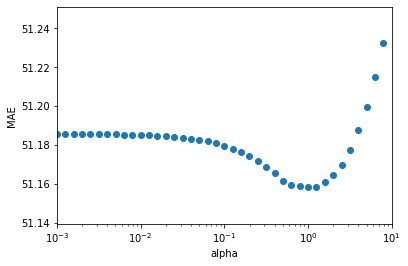

In [51]:
alphas = 0.0001 * 10**np.arange(1,5,0.1)
maes = []
for alpha in alphas:
    lr = Ridge(alpha = alpha)
    lr.fit(X_train, y_train)

    # predict result using test data
    y_pred = lr.predict(X_test)
    maes.append(metrics.mean_absolute_error(y_test, y_pred))
plt.scatter(alphas, maes)
plt.xscale('log')
plt.xlim(0.001, 10)
plt.xlabel('alpha')
plt.ylabel('MAE')

In [52]:
lr = Lasso(alpha = 0.1)
lr.fit(X_train, y_train)

# predict result using test data
y_pred = lr.predict(X_test)

print('MAE = ', '{:.3f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('RMSE = ','{:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('R2 score = ', '{:.3f}'.format(metrics.r2_score(y_test, y_pred)))

MAE =  51.389
RMSE =  70.389
R2 score =  0.509


## Decision Tree, Random Forest, XGBoost

In [53]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [54]:
y_pred = clf.predict(X_test)

In [55]:
print('MAE = ', '{:.3f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('RMSE = ','{:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('R2 score = ', '{:.3f}'.format(metrics.r2_score(y_test, y_pred)))

MAE =  56.538
RMSE =  86.624
R2 score =  0.256


In [56]:
df_temp = pd.DataFrame({'price':y_test, 'predicted price': y_pred}).sample(10)
df_temp.apply(np.floor).astype(object)

price predicted price
3078   300             350
1194   360             450
2550   111              81
6009    44              57
5805   213             163
5675   185             199
3990   100             110
4366   117              95
3710   100              80
3498   240              80

In [57]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth = 11)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [58]:
print('MAE = ', '{:.3f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('RMSE = ','{:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('R2 score = ', '{:.3f}'.format(metrics.r2_score(y_test, y_pred)))

MAE =  52.306
RMSE =  78.670
R2 score =  0.386


In [59]:
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth = 2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [60]:
print('MAE = ', '{:.3f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('RMSE = ','{:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('R2 score = ', '{:.3f}'.format(metrics.r2_score(y_test, y_pred)))

MAE =  55.427
RMSE =  83.762
R2 score =  0.304


## Neural Network

In [65]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam

model = Sequential([
    Dense(64, activation = 'relu', input_shape = (77,)),
    Dropout(0.1),
    Dense(32, activation = 'relu'),
    Dropout(0.1),
    Dense(1)
])
opt = Adam(learning_rate = 0.001)
model.compile(loss = 'mean_squared_error', optimizer = opt)


In [66]:
X_test2.shape

(1696, 77)

In [67]:
X_val, X_test2, y_val, y_test2 = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)
hist = model.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data = (X_val, y_val),
                verbose = 0)
y_pred2 = model.predict(X_test2)

In [68]:
print('MAE = ', '{:.3f}'.format(metrics.mean_absolute_error(y_test2, y_pred2)))
print('RMSE = ','{:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test2, y_pred2))))
print('R2 score = ', '{:.3f}'.format(metrics.r2_score(y_test2, y_pred2)))

MAE =  46.229
RMSE =  66.387
R2 score =  0.545


In [69]:
df_temp = pd.DataFrame({'price':y_test2, 'predicted price': y_pred2[:,0]}).sample(10)
df_temp.apply(np.floor).astype(object)

price predicted price
8319   280             178
4272   350             349
5347    80              82
979    287             237
3349   188             129
1406    55              33
3270   350             243
2766    99              82
3637    92             144
3440   125              90

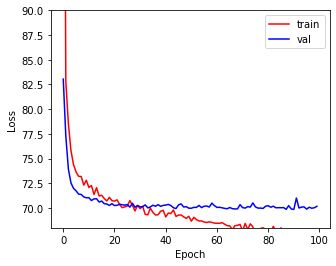

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(np.sqrt(hist.history['loss']), 'r', label='train')
ax.plot(np.sqrt(hist.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
ax.set_ylim(68,90)
ax.legend()

### Hyper parameter tuning

In [72]:
from tqdm import tqdm
lrs = 0.000001 * 10**np.arange(0,8,0.2)
val_losses = []
for lr in tqdm(lrs):
    model = Sequential([
        Dense(64, activation = 'relu', input_shape = (77,)),
        Dense(32, activation = 'relu'),
        Dense(1)
    ])
    opt = Adam(learning_rate = lr)
    model.compile(loss = 'mean_squared_error', optimizer = opt)
    hist = model.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data = (X_val, y_val),
                    verbose = 0)
    val_losses.append(np.sqrt(hist.history['val_loss'][-1]))

100%|██████████| 40/40 [16:22<00:00, 24.55s/it]


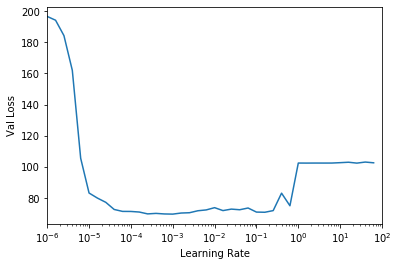

In [73]:
plt.plot(lrs, val_losses)
plt.xscale('log')
plt.xlim(0.000001, 100);
plt.xlabel('Learning Rate');
plt.ylabel('Val Loss');

In [74]:
drops = list(np.arange(0.01,0.2,0.002))
val_losses = []
for drop in tqdm(drops):
    model = Sequential([
        Dense(64, activation = 'relu', input_shape = (77,)),
        Dropout(drop),
        Dense(32, activation = 'relu'),
        Dropout(drop),
        Dense(1)
    ])
    opt = Adam(learning_rate = 0.001)
    model.compile(loss = 'mean_squared_error', optimizer = opt)
    hist = model.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data = (X_val, y_val),
                    verbose = 0)
    val_losses.append(np.sqrt(hist.history['val_loss'][-1]))

100%|██████████| 95/95 [42:34<00:00, 26.89s/it]


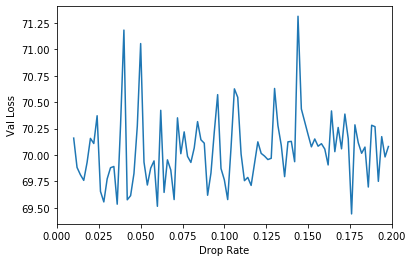

In [75]:
plt.plot(drops, val_losses)
plt.xlim(0, 0.2);
plt.xlabel('Drop Rate');
plt.ylabel('Val Loss');

### Conclusions

Our findings are:
1. Most Airbnb rentals in San Francisco are in the north-east coastal areas.
2. Prices in most neighbors are skewed to the right. The Downtown/Civic area, while having the lowest average price, shows a bimodal distribution. This suggests a gap between the rich and the poor.
3. Superhosts, in general, provide better renting experience, their rating in all aspects were 0.2 - 0.4 higher in rating than regular hosts.
4. We have used multiple machine learning algorithms to successfully make an estimation for Airbnb rent price. In which Neural Network Regression has the best performance with a 55% R2 score.